In [1]:
#@markdown # Import Google Drive
#@markdown Click 'Run' button to mount Google Drive files to the Colab session
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
#@markdown # Import statements - Click 'Run' to import
#@markdown - existing Python libraries
#@markdown - auxiliary .py files from drive

import numpy as np
#import jax.numpy as jnp
#from jax import jit, vmap
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
#from jax import random
import time

import sys
sys.path.append('/content/drive/MyDrive/Langevin Sampling/py_files')
import distributions as pd

# Implementation Steps
- PSGL Algorithm:
  - 🌱 batch sampling
  - 🌱 prox operator of L1/TV? L1 easy (soft shrinkage), TV iteratively, translate existing primal-dual MATLAB code
- Implement forward model: Convolution via Fourier Transform & kernel multiplication
- Implement adjoint of forward model
- 🌱 Data generation: 
  - 🌱 Generate clean image, 
  - apply forward operator, 
  - 🌱 apply Poisson process

# Forward operator
Easiest case: Denoising from Poisson data. Given clean image $u_{true}$, measure a realization $y$ of the r.v. $Y \sim \textrm{Pois}(u_{true} + r)$ with some background $r$.



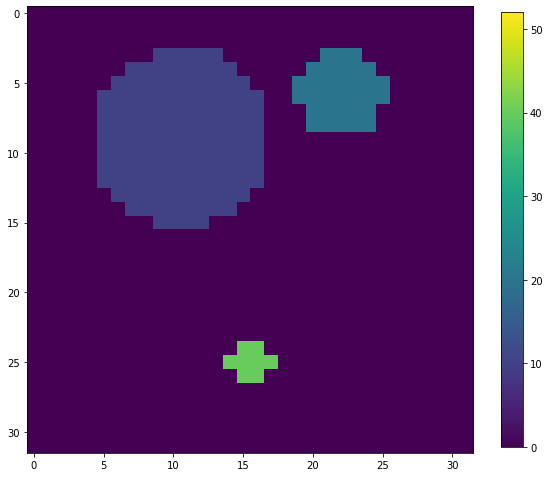

In [3]:
#@markdown # Create and display ground truth image
nX = 32
nY = 32
I,J = np.meshgrid(np.arange(1,nX+1),np.arange(1,nY+1))
#@markdown Phantom consisting of three circles with different intensites
circles = {'Mx': [0.35,0.7,0.5], 'My': [0.3,0.2,0.8], 'rad': [0.2,0.1,0.05], 'level': [10,20,40]}
circle1 = ((I-(nX+1)*circles['Mx'][0])**2 + (J-(nY+1)*circles['My'][0])**2 < (nX*circles['rad'][0])**2)*circles['level'][0]
circle2 = ((I-(nX+1)*circles['Mx'][1])**2 + (J-(nY+1)*circles['My'][1])**2 < (nX*circles['rad'][1])**2)*circles['level'][1]
circle3 = ((I-(nX+1)*circles['Mx'][2])**2 + (J-(nY+1)*circles['My'][2])**2 < (nX*circles['rad'][2])**2)*circles['level'][2]
u_true = circle1 + circle2 + circle3

fig, axs = plt.subplots(1,1,figsize=(10,10))
plot_ground_truth = axs.imshow(u_true,vmin=0,vmax=np.max(np.array(circles['level']))*1.3)
plt.colorbar(plot_ground_truth, ax=axs, shrink=0.8)

--- TODO : apply some more interesting forward operator, e.g. convolution by mapping into Fourier space and multiplying, or Radon transform ---

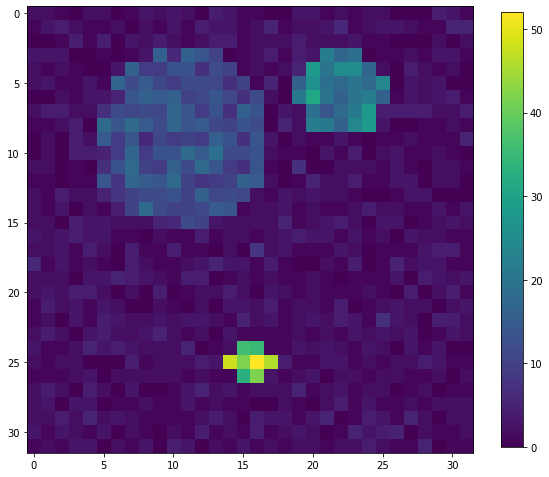

In [4]:
#@markdown # Create measurement by sampling from Poisson process
#@markdown Measurement component $y_i$ is realization of $Y_i \overset{ind.}{\sim} \textrm{Pois}(u^{true}_i + r_i)$, where $u^{true}$ is the image above and $r_i$ is some background level.

# randomness auxiliaries
rng = default_rng()

# set background
background_level = 2
r = np.ones_like(u_true)*background_level
u_noisy_poisson = rng.poisson(u_true + r)

fig, axs = plt.subplots(1,1,figsize=(10,10))
plot_noisy_poisson = axs.imshow(u_noisy_poisson,vmin=0,vmax=np.max(np.array(circles['level']))*1.3)
plt.colorbar(plot_ground_truth, ax=axs, shrink=0.8)

In [5]:
#@markdown # Define the proximal mapping of TV
#@markdown Defines 2D discretized divergence div2D, gradient operator grad2D and prox_TV2D(x, gamma) that computes an approximation to the solution of 
#@markdown $$\min_u \left\{\frac{1}{2\gamma}\lVert u-x \rVert_2^2 + \mathrm{TV}(u)\right\}$$
def div2D(fx,fy):
    # divergence operator
    # maybe assert equal size here
    d = np.concatenate((np.reshape(fx[0,:],(1,nY)), fx[1:-1,:]-fx[0:-2,:], np.reshape(-fx[-2,:],(1,nY))), axis=0) \
    + np.concatenate((np.reshape(fy[:,0],(nX,1)), fy[:,1:-1]-fy[:,0:-2], np.reshape(-fy[:,-2],(nX,1))), axis=1)
    return d

def grad2D(f):
    fx = np.pad(f[1:,:] - f[0:-1,:], pad_width = ((0,1),(0,0)))
    fy = np.pad(f[:,1:] - f[:,0:-1], pad_width = ((0,0),(0,1)))
    return fx, fy

def prox_TV2D(x, gamma, dims=None, max_iter=100, verbose=False):
  # computes argmin_u {1/(2*gamma)||x-u||_2^2 + TV(u)}
  # using the method from Chambolle, 2004: An Algorithm for Total Variation Minimization and Applications.
  # Input:  - x: 2D signal that is denoised
  #         - gamma: regularization parameter
  #         - dims: x might be given as a 1D vector for convenience. If that is the case, give dims to reshape x. Default 'None', don't reshape.
  #         - maxiter: Maximum number of iterations in the dual space. Default = 100
  #         - verbose: Shows the iteration errors that are checked for the stopping criterion. Default = False
  if not dims is None:
    x = np.reshape(x, dims)
  px = np.zeros_like(x)
  py = np.zeros_like(x)
  stopcrit = False
  tau = 1/8
  iter = 0
  while not stopcrit:
    iter = iter+1
    poldx = px
    poldy = py
    rx, ry = grad2D(div2D(px,py) - x/gamma)
    px = (poldx + tau*rx)/(1 + tau*np.abs(rx))
    py = (poldy + tau*ry)/(1 + tau*np.abs(ry))
    stopcrit = (np.max(np.abs(px-poldx)) < 10**(-4) and np.max(np.abs(py-poldy)) < 10**(-4))\
    or iter == max_iter
    if verbose:
      print('Iteration {:4d}: ||px - px_new||_inf = {:10.4f}; ||py - py_new||_inf = {:10.4f}\n'.format(iter, np.max(np.abs(px-poldx)), np.max(np.abs(py-poldy))))
  q = div2D(px,py)
  return np.maximum(x - gamma*q, np.zeros_like(x))

elapsed time: 0.013900384999999904 s



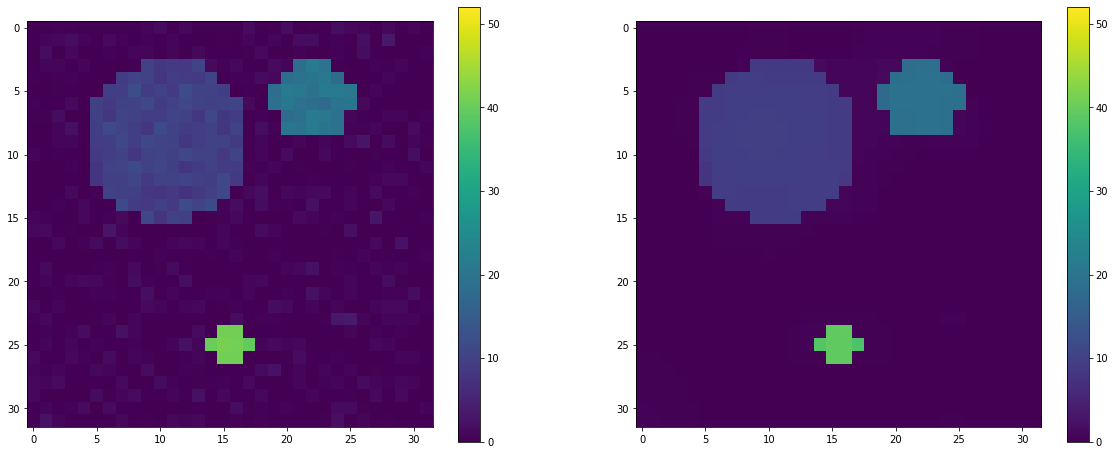

In [6]:
#@markdown # Test TV Prox
#@markdown This cell adds Gaussian noise to the ground truth and computes the TV-regularized denoised version.
#@markdown Run it to test that the TV prox implementation works or play with the parameters.
fig, axs = plt.subplots(1,2,figsize=(20,20))
u_noisy_gaussian = rng.normal(size=(nX, nY)) + u_true
plot_noisy_gaussian = axs[0].imshow(u_noisy_gaussian,vmin=0,vmax=np.max(np.array(circles['level']))*1.3)
plt.colorbar(plot_noisy_gaussian, ax=axs[0], shrink=0.4)

max_iter_TVprox = 50
mu_TV = 1
start_time = time.process_time()
u_denoised_gaussian = prox_TV2D(u_noisy_gaussian, mu_TV, (nX,nY), max_iter_TVprox, verbose=False)
print('elapsed time: ' + str(time.process_time() - start_time) + ' s\n')
plot_denoised_gaussian = axs[1].imshow(u_denoised_gaussian,vmin=0,vmax=np.max(np.array(circles['level']))*1.3)
plt.colorbar(plot_denoised_gaussian, ax=axs[1], shrink=0.4)

In [7]:
#@markdown # Define a stochastic batch version of $\nabla\mathrm{KL}(u+r,v)$
def grad_KL_stochBatch(u,v,b,batch,batch_size=None):
  # Input:  v = measurement
  #         u = estimated signal
  #         b = background
  #         batch = batch indices array
  #         batch_size = batch.size()
  # when calling, make sure that S is an array of length batch_size
  if batch_size is None: batch_size = batch.size()
  d = v.size
  scale = d/batch_size
  g = np.zeros_like(u)
  for i in batch:
    g[i,:] = scale*(1 - v[i]/(u[i,:]+b[i]))
  return g

In [8]:
#@markdown # PSGLA implementation
#@markdown Set algorithm parameters, run diffusion model by PSGLA. Let the potential be given by 
#@markdown $$V(x) = F(x) + \mu G(x)$$
#@markdown and assume we have access to a stochastic version of $F$, i.e. $v(x,\xi) = f(x,\xi) + \mu G(x)$ with
#@markdown $$\begin{align*} \mathbb{E}_\xi[v(x,\xi)] &= \mathbb{E}_\xi\left[ f(x,\xi) \right] + \mu G(x) \\ &= F(x) + \mu G(x) \\ &= V(x)\end{align*} $$
#@markdown Then the update formula is given by:
#@markdown $$\begin{align*} \eta_{k+1} &\overset{i.i.d.}{\sim}\mathcal{N}(0,1),\\ S_{k+1} &\subset \left\{1,\dots,N\right\}\\ X_{k+1} &= \mathrm{prox}_{\tau\mu G} \left\{X_k - \tau \nabla v(X_k,S_{k+1}) + \sqrt{2\tau}\,\eta_{k+1} \right\}.\end{align*}$$

def PSGLA(y, r, nX, nY, n_samples, batch_size, tau0, max_iter, mu_TV):
  X = np.zeros((nX*nY, n_samples))
  r = np.reshape(r,(nX*nY,1))
  y = np.reshape(y,(nX*nY,1))
  for i in np.arange(max_iter):
    tau=tau0/(i+1)

    # choose stochastic batch of indices to update
    S = rng.choice(nX*nY, size=(batch_size,), replace=False)
    
    # sample random normal and perform ULA update with stochastic F
    xi = rng.normal(size=(nX*nY, n_samples))
    W = X - tau*grad_KL_stochBatch(X,y,r,S,S.size) + np.sqrt(2*tau)*xi

    # apply prox of tau*mu*G
    for j in np.arange(n_samples):
      X[:,j] = np.reshape(prox_TV2D(np.reshape(W[:,j],(nX,nY)), tau*mu_TV, max_iter=50), (nX*nY,))
  
  return X

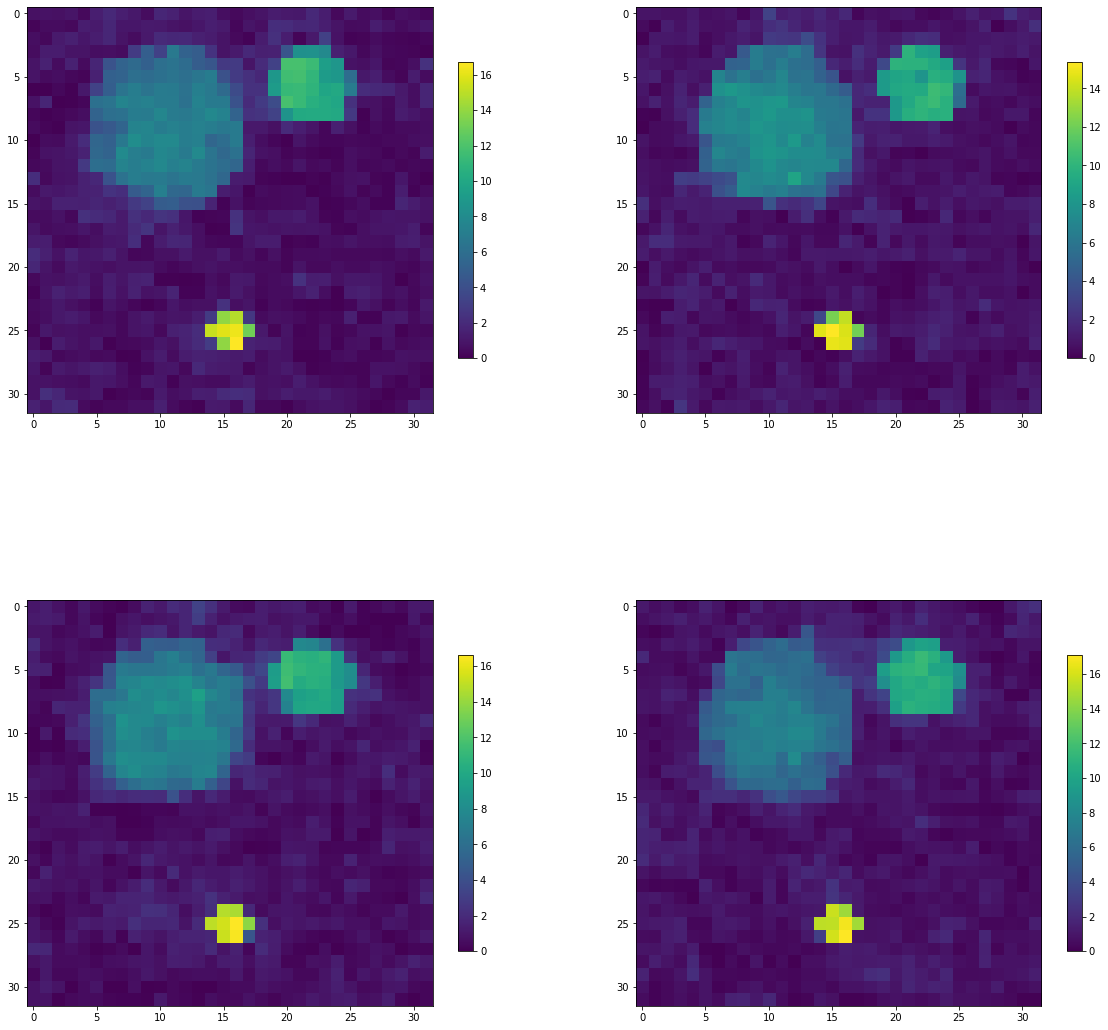

In [9]:
#@markdown **Run PSGLA with 4 samples, a batch size of 100 pixels (from 1024 in total), 1000 iteration steps with decaying step sizes and $\mu_{TV} = 1$.**
n_samples = 4
batch_size = 1024
T = 5
tau0 = 1
max_iter = 1000
mu_TV = 1 # TV regularization parameter
X1 = PSGLA(u_noisy_poisson, r, nX, nY, n_samples, batch_size, tau0, max_iter, mu_TV)

fig, axs = plt.subplots(2,2,figsize=(20,20))
for k1 in np.arange(2):
  for k2 in np.arange(2):
    plot_samplek = axs[k1,k2].imshow(np.reshape(X1[:,k1*2+k2],(nX,nY)))
    plt.colorbar(plot_samplek,ax=axs[k1,k2], shrink=0.6)

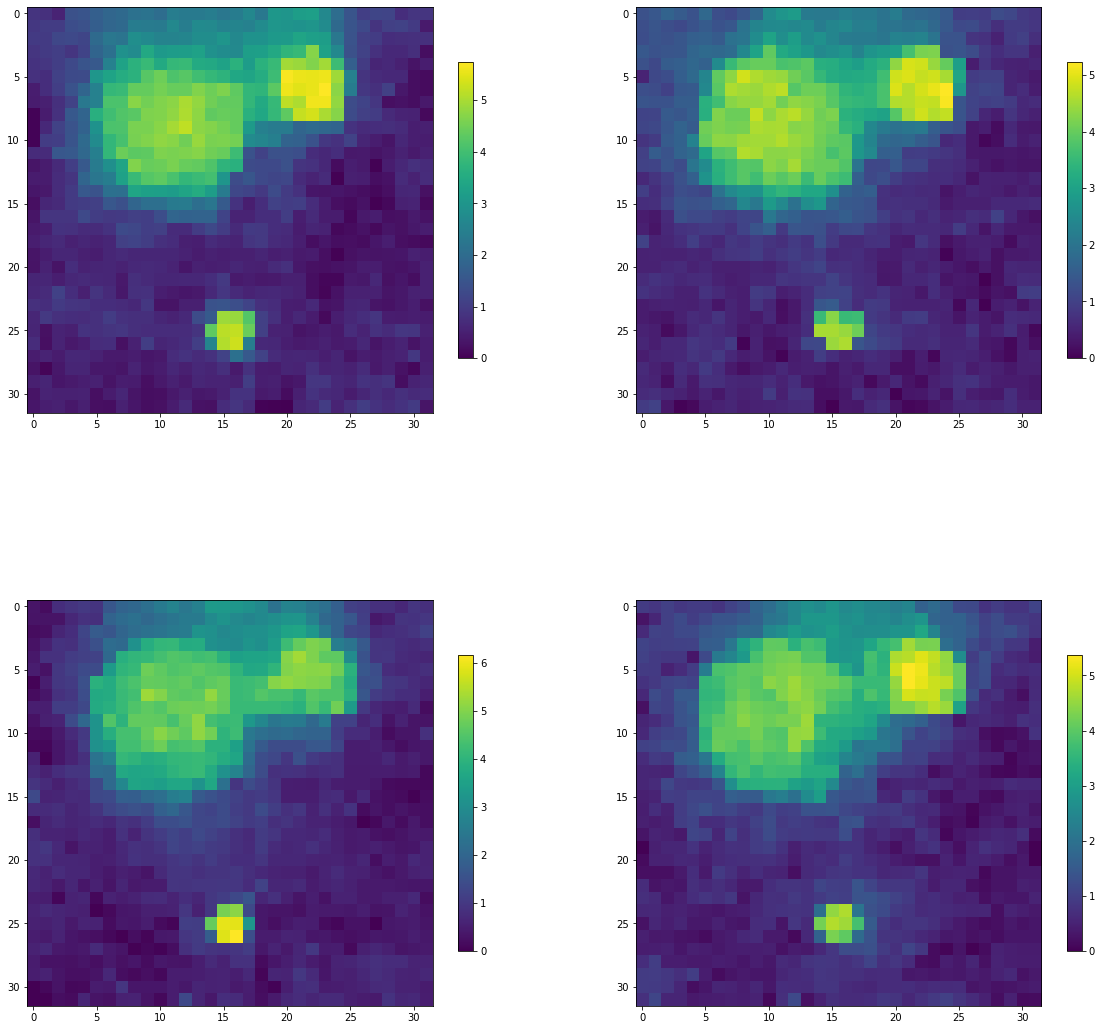

In [10]:
#@markdown **Run PSGLA with same setting as before, but $\mu_{TV} = 3$.**

mu_TV = 3 # TV regularization parameter
X5 = PSGLA(u_noisy_poisson, r, nX, nY, n_samples, batch_size, tau0, max_iter, mu_TV)

fig, axs = plt.subplots(2,2,figsize=(20,20))
for k1 in np.arange(2):
  for k2 in np.arange(2):
    plot_samplek = axs[k1,k2].imshow(np.reshape(X5[:,k1*2+k2],(nX,nY)))
    plt.colorbar(plot_samplek,ax=axs[k1,k2], shrink=0.6)